# InCURA Tutorial - Recover gene signatures in cluster

### In this tutorial we show how you can analyse your InCURA clusters for gene signatures of interest. Please note that this analysis workflow is not part of the main InCURA workflow. It is simply a suggestion and should showcase how the clusters created by InCURA can be investigated downstream. 


### Import of packages

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from sklearn.manifold import TSNE
from umap import UMAP
import seaborn as sns
import scanpy as sc
import scipy.cluster.hierarchy as sch
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
import re
from datetime import datetime

# Needed for some plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Create a timestamp string
timestamp = datetime.now().strftime("%Y%m%d")

pd.set_option('display.max_rows', 500)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
custom_colors = ['#e8ba41', '#b1a73e', '#b93c6d', '#b4d6e7', 'grey']

### Load data

In [2]:
# Set path variable
path = 'tutorial_data/'

### Here we load the individual gene lists that contain all members of one cluster.

In [3]:
cluster0 = pd.read_csv(path + 'Count_cluster0_genes_k4.tsv', sep='\t')
cluster1 = pd.read_csv(path + 'Count_cluster1_genes_k4.tsv', sep='\t')
cluster2 = pd.read_csv(path + 'Count_cluster2_genes_k4.tsv', sep='\t')
cluster3 = pd.read_csv(path + 'Count_cluster3_genes_k4.tsv', sep='\t')

### Check for enrichment of gene signatures in the resulting InCURA clusters.
### For demonstration we use the markers for CD8+ effector T cells from the mouse dataset by [Khan et al., 2019](https://pubmed.ncbi.nlm.nih.gov/31207603/) that we have also used as one of our case studies. 

### In this studies the authors explicitly name a collection of genes that plan an important role in T cell fate determination. In particular, they seem to drive the effector T cell state. We used this signatures to investigate whether we can recapitulate an InCURA-generated cluster of genes that is funcionally related to the effector T cell state by performing enrichment analysis of the curated gene signature. 

In [4]:
# Define marker genes for T cell subsets
Teff_genes = ['Klrg1', 'Clnk', 'Gzma', 'Zeb2', 'Cxcr1', 'Fasl', 'Prf1', 'Ccr5', 'Havcr2', 'Ly6c2', 'Ifng', 'Gzmk', 'Nr4a1', 'Gzmb', 'Ccl3']

### Define enrichment analysis function

In [11]:
dfs = {'Cluster 0': cluster0, 'Cluster 1': cluster1, 'Cluster 2': cluster2, 'Cluster 3': cluster3}

# List of marker genes
marker_genes = set(Teff_genes)  # Replace with your marker genes
all_genes = set(pd.concat(dfs.values())['symbols'])  # All genes across all clusters

# Perform enrichment test for each cluster
results = []
for cluster, df in dfs.items():
    cluster_genes = set(df['symbols'])  # Genes in this cluster

    # Define contingency table
    a = len(cluster_genes & marker_genes)       # Marker genes in cluster
    b = len(cluster_genes - marker_genes)       # Non-marker genes in cluster
    c = len(marker_genes - cluster_genes)       # Marker genes not in cluster
    d = len(all_genes - cluster_genes - marker_genes)  # Non-marker genes not in cluster

    # Fisher's exact test
    odds_ratio, p_value = fisher_exact([[a, b], [c, d]], alternative="greater")
    
    results.append({"Cluster": cluster, "Marker Genes in Cluster": a, 
                    "p-value": p_value, "Odds Ratio": odds_ratio})

# Convert results to DataFrame
df_Teff = pd.DataFrame(results).sort_values("Cluster")

# Add corrected p-values (FDR)
pvals = df_Teff["p-value"].values
_, pvals_corrected, _, _ = multipletests(pvals, method='fdr_bh')

df_Teff["p-adj"] = pvals_corrected

### The above function creates the following dataframe by testing if our marker genes are significantly more present in one of the clusters than in all the others.

In [12]:
df_Teff

,Cluster,Marker Genes in Cluster,p-value,Odds Ratio,p-adj
0,Cluster 0,1,0.996754,0.152639,1.000000
1,Cluster 1,0,1.000000,0.000000,1.000000
2,Cluster 2,11,0.004765,4.718680,0.019059
3,Cluster 3,1,0.914769,0.399845,1.000000


### Plot heatmap

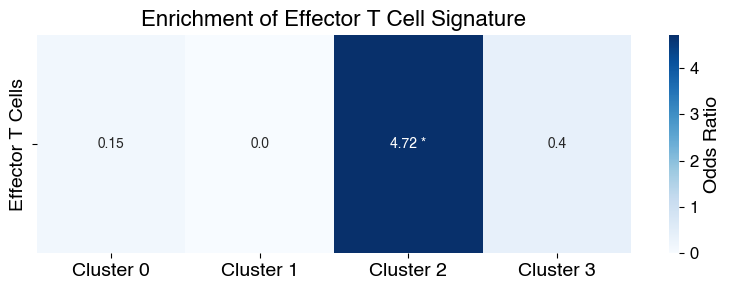

In [18]:
# Tag each dataframe with the corresponding signature name
df_Teff['Signature'] = 'Effector T Cells'

# Pivot into heatmap format: rows = signature, columns = cluster
heatmap_data = df_Teff.pivot(index='Signature', columns='Cluster', values='Odds Ratio')

# Create a boolean mask for significant values (p ≤ 0.05)
df_Teff['significant'] = df_Teff['p-adj'] <= 0.05

# Create annotations with asterisks for significant cells
annot_matrix = df_Teff.pivot(index='Signature', columns='Cluster', values='Odds Ratio').round(2).astype(str)
sig_mask = df_Teff.pivot(index='Signature', columns='Cluster', values='significant')

# Add '*' where significant
annot_matrix = annot_matrix.where(~sig_mask, annot_matrix + ' *')

# Plot heatmap
plt.figure(figsize=(8, 3))
ax = sns.heatmap(heatmap_data, annot=annot_matrix, fmt="", cmap="Blues", cbar_kws={'label': 'Odds Ratio'})

# Customize colorbar font sizes
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=12)               # Tick label font size
colorbar.ax.set_ylabel('Odds Ratio', fontsize=14)

plt.title("Enrichment of Effector T Cell Signature", fontsize=16)
plt.xlabel("")
plt.ylabel("")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(path + f'enrichment_heatmap_per_cluster_odds_{timestamp}.svg', bbox_inches='tight')
plt.show()